# Perform some initial analysis on the results of the SnapATAC2 pipeline
**Authorship:** Adam Klie (last updated: 08/22/2023)<br>
***
**Description:** Notebook to plot and plan next steps from a baseline SnapATAC2 run. Expects that you have run all steps up to and including `7_analyze_anndataset.sh`. This is somewhat of a playground and thus will need to be interactive.

# Set-up

In [25]:
# Import packages
import os
import numpy as np
import pandas as pd
import snapatac2 as snap
import scanpy as sc

In [26]:
barcodes_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/annotations.txt"
barcodes = pd.read_csv(barcodes_path, header=None, index_col=0, sep="\t")
barcodes = barcodes.index.tolist()

In [27]:
adata = snap.read("/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/sample/dm14b/snapatac2/clustered_obsm_delete.h5ad")
adata

AnnData object with n_obs x n_vars = 2761 x 606219 backed at '/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/sample/dm14b/snapatac2/clustered_obsm_delete.h5ad'
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'log_n_fragment', 'doublet_probability', 'doublet_score', 'leiden_1'
    var: 'count', 'selected'
    uns: 'reference_sequences', 'doublet_rate', 'scrublet_sim_doublet_score', 'spectral_eigenvalue', 'frag_size_distr', 'leiden_1_colors'
    obsm: 'fragment_paired'
    obsp: 'distances'

In [28]:
adata.subset(obs_indices=np.where(pd.Index(adata.obs_names).isin(barcodes))[0])
adata

AnnData object with n_obs x n_vars = 2761 x 606219 backed at '/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/sample/dm14b/snapatac2/clustered_obsm_delete.h5ad'
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'log_n_fragment', 'doublet_probability', 'doublet_score', 'leiden_1'
    var: 'count', 'selected'
    uns: 'reference_sequences', 'doublet_rate', 'scrublet_sim_doublet_score', 'spectral_eigenvalue', 'frag_size_distr', 'leiden_1_colors'
    obsm: 'fragment_paired'
    obsp: 'distances'

In [29]:
adata.close()

In [37]:
adataset = snap.read_dataset("/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse/A2_ext4/snapatac2/merged.h5ads")

In [38]:
len(adataset.obs_names)

35106

In [32]:
adata = adataset.to_adata()

ValueError: Length of passed value for obs_names is 35106, but this AnnData has shape: (29846, 606219)

In [ ]:
sc.pl.umap(adata, color="leiden_1")

AttributeError: 'builtins.AnnDataSet' object has no attribute '_sanitize'

In [35]:
adataset.close()

In [4]:
# Paths
input_h5ad_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/16Aug23/snapatac2/processed/adata_atac_MO1_processed.h5ad"

# Load the data

In [3]:
# Load h5ad
adata = sc.read_h5ad(input_h5ad_path)
adata

AnnData object with n_obs × n_vars = 2780 × 606219
    obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito', 'doublet_probability', 'doublet_score'
    var: 'count', 'selected'
    uns: 'reference_sequences', 'scrublet_sim_doublet_score'
    obsm: 'insertion'

# Quick checks

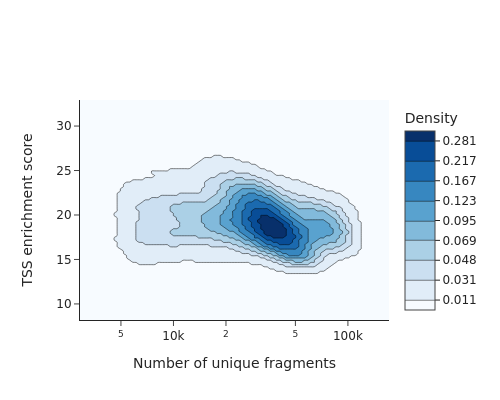

In [5]:
# Plot tsse
snap.pl.tsse(adata, interactive=False)

In [8]:
# How many cells are kept?
adata_mem.obs["kept"] = snap.pp.filter_cells(adata_mem, min_counts=10000, min_tsse=10, max_counts=65000, inplace=False).values
adata_mem.obs["kept"].value_counts()

True     7927
False    3000
Name: kept, dtype: int64

In [9]:
# Actually perform the filtering
adata_pp = adata_mem[adata_mem.obs["kept"]].copy()

In [10]:
snap.pp.add_tile_matrix(adata_pp)

In [11]:
snap.pp.select_features(adata_pp, n_features=250000)

2023-10-18 14:03:31 - INFO - Selected 250000 features.


In [35]:
#snap.pp.scrublet(adata_pp)

In [14]:
adata_pp.var["selected"].value_counts()

False    5812095
True      250000
Name: selected, dtype: int64

In [15]:
snap.tl.spectral(adata_pp)

In [17]:
snap.tl.umap(adata_pp)

In [19]:
snap.pp.knn(adata_pp)
snap.tl.leiden(adata_pp)

In [21]:
snap.pl.umap(adata_pp, color='leiden', show=True, height=500)

In [22]:
gene_matrix = snap.pp.make_gene_matrix(adata_pp, snap.genome.hg38)

In [23]:
gene_matrix

AnnData object with n_obs × n_vars = 7927 × 60606
    obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito', 'kept', 'leiden'

In [25]:
import scanpy as sc

In [26]:
sc.pp.filter_genes(gene_matrix, min_cells=5)
sc.pp.normalize_total(gene_matrix)
sc.pp.log1p(gene_matrix)

In [27]:
sc.external.pp.magic(gene_matrix, solver="approximate")

In [28]:
gene_matrix.obsm["X_umap"] = adata_pp.obsm["X_umap"]

In [29]:
# Define global run parameters
marker_genes = {
    "SC.beta": ["INS", "IAPP", "PDX1", "ISL1"],
    "SC.pre.alpha": ["ARX"],
    "SC.alpha": ["GCG"],
    "SC.delta": ["SST"],
    "SC.EC": ["TPH1", "CHGA", "NKX6-1"],
    "progenitor": ["PTF1A", "NEUROG3", "ZEB2", "SOX9"]
}

In [36]:
gene_matrix.X

array([[ 7.73682912e-02,  1.16289052e-02,  3.91586273e-03, ...,
         4.29826684e-03,  1.06151272e-03, -7.68252109e-04],
       [ 8.39473659e-02,  1.40886580e-02,  5.17575371e-03, ...,
         5.16964779e-03,  6.32865626e-05,  2.32026775e-03],
       [ 8.10675733e-02,  1.53462617e-02,  5.32161649e-03, ...,
         7.89113349e-03,  1.59755008e-03,  1.25417746e-03],
       ...,
       [ 7.34879046e-02,  1.58906441e-02,  5.52164563e-03, ...,
         8.12777849e-03,  1.67701489e-03,  6.16033355e-04],
       [ 7.94008358e-02,  1.65445299e-02,  5.07096847e-03, ...,
         2.19355856e-03,  9.07201805e-04,  9.75264884e-04],
       [ 7.87991194e-02,  1.44400057e-02,  3.92459993e-03, ...,
         3.09297273e-03, -8.48279322e-05,  2.01692922e-03]])

In [32]:
marker_genes_in_data = dict()
for ct, markers in marker_genes.items():
    markers_found = list()
    for marker in markers:
        if marker in gene_matrix.var.index:
            markers_found.append(marker)
    marker_genes_in_data[ct] = markers_found
marker_genes_in_data

{'SC.beta': ['INS', 'IAPP', 'PDX1', 'ISL1'],
 'SC.pre.alpha': ['ARX'],
 'SC.alpha': ['GCG'],
 'SC.delta': ['SST'],
 'SC.EC': ['TPH1', 'CHGA', 'NKX6-1'],
 'progenitor': ['PTF1A', 'NEUROG3', 'ZEB2', 'SOX9']}

... storing 'leiden' as categorical


SC.BETA:


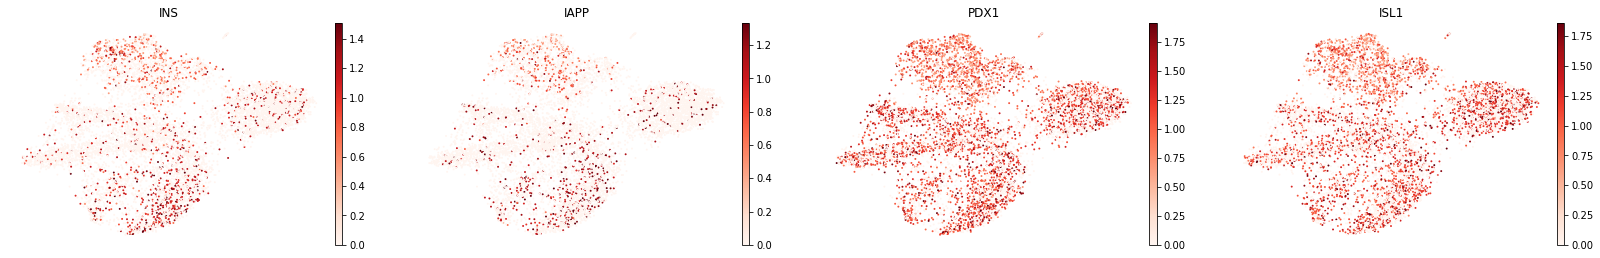





SC.PRE.ALPHA:


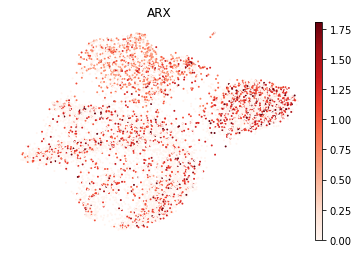





SC.ALPHA:


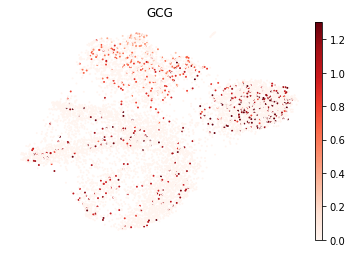





SC.DELTA:


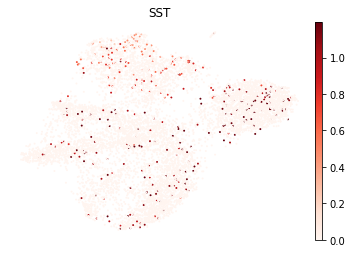





SC.EC:


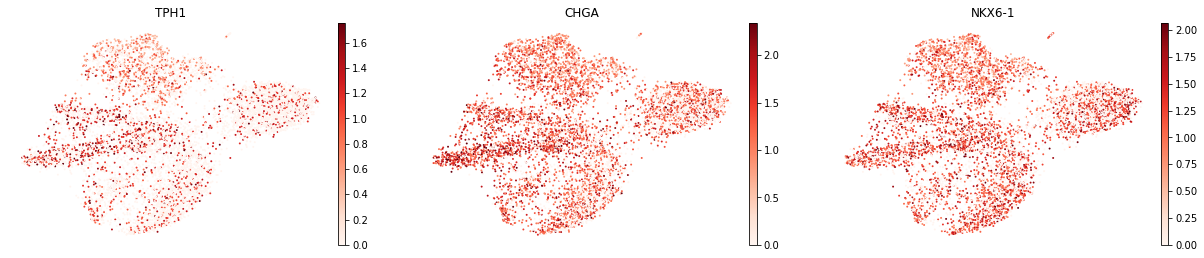





PROGENITOR:


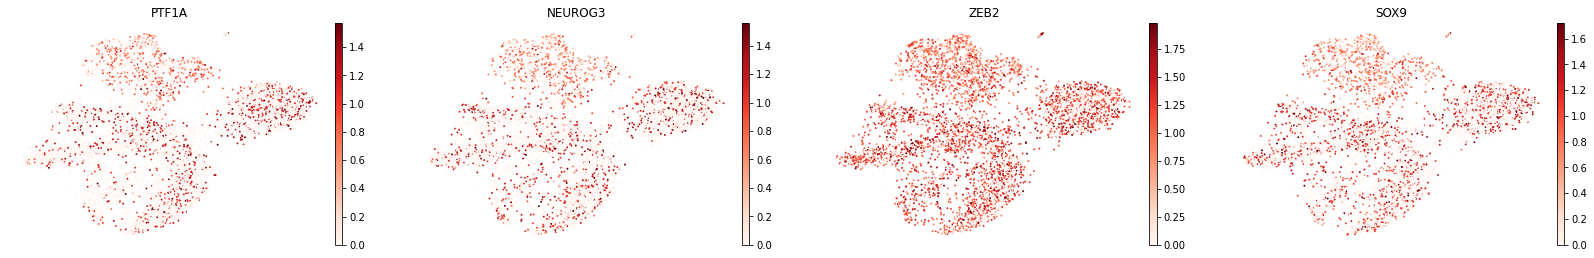

In [35]:
for ct in marker_genes_in_data.keys():
    print(f"{ct.upper()}:")  # print cell subtype name
    sc.pl.umap(
        gene_matrix,
        color=marker_genes_in_data[ct],
        vmin=0,
        vmax="p99",  # set vmax to the 99th percentile of the gene count instead of the maximum, to prevent outliers from making expression in other cells invisible. Note that this can cause problems for extremely lowly expressed genes.
        sort_order=False,  # do not plot highest expression on top, to not get a biased view of the mean expression among cells
        frameon=False,
        cmap="Reds",  # or choose another color map e.g. from here: https://matplotlib.org/stable/tutorials/colors/colormaps.html
    )
    print("\n\n\n")  # print white space for legibility